In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Ensures backend compatibility in Kaggle environments
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # For cases when only plt is imported

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance

# Ensure plots are rendered inline for Kaggle
%matplotlib inline

# Set plot style for better aesthetics
sns.set(style='whitegrid')

### Data Loading

In [4]:
data_path = '/Users/arunaa/ML/Greenhouse-Plant-Growth-Analysis/Greenhouse Plant Growth Metrics.csv'

try:
    df = pd.read_csv(data_path, delimiter=',', encoding='ascii')
    print('Data loaded successfully.')
except Exception as e:
    print(f'Error loading data: {e}')

df.head()

Data loaded successfully.


,Random,ACHP,PHR,AWWGV,ALAP,ANPL,ARD,ADWR,PDMVG,ARL,AWWR,ADWV,PDMRG,Class
0,R1,34.533468,54.566983,1.147449,1284.229549,4.999713,16.274918,1.706810,18.399982,19.739037,2.949240,0.209251,57.633906,SA
1,R1,34.489028,54.567692,1.149530,1284.247744,5.024259,16.269452,1.700930,18.398289,19.758836,2.943137,0.216154,57.633697,SA
2,R2,33.100405,67.067344,1.104647,1009.208996,5.007652,15.980760,1.185391,19.398789,20.840822,2.861635,0.200113,41.289875,SA
3,R1,34.498319,54.559049,1.137759,1284.227623,4.991501,16.276710,1.716396,18.413613,19.736098,2.946784,0.223092,57.645661,SA
4,R3,36.297008,45.588894,1.363205,981.470310,4.003682,16.979894,0.777428,31.423772,17.331894,2.766242,0.424172,27.898619,SA


### Data Cleaning and Preprocessing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Random  30000 non-null  object 
 1   ACHP    30000 non-null  float64
 2   PHR     30000 non-null  float64
 3   AWWGV   30000 non-null  float64
 4   ALAP    30000 non-null  float64
 5   ANPL    30000 non-null  float64
 6   ARD     30000 non-null  float64
 7   ADWR    30000 non-null  float64
 8   PDMVG   30000 non-null  float64
 9   ARL     30000 non-null  float64
 10  AWWR    30000 non-null  float64
 11  ADWV    30000 non-null  float64
 12  PDMRG   30000 non-null  float64
 13  Class   30000 non-null  object 
dtypes: float64(12), object(2)
memory usage: 3.2+ MB


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

# If missing values are found in numeric columns, we may choose to impute or remove observations
if missing_values.sum() > 0:
    # For the sake of this analysis, we'll fill numeric missing values with the column mean
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    # For object types, fill missing values with a placeholder 'Unknown'
    object_cols = df.select_dtypes(include=['object']).columns
    df[object_cols] = df[object_cols].fillna('Unknown')
    print('Missing values were imputed.')
else:
    print('No missing values found.')

Missing values in each column:
Random    0
ACHP      0
PHR       0
AWWGV     0
ALAP      0
ANPL      0
ARD       0
ADWR      0
PDMVG     0
ARL       0
AWWR      0
ADWV      0
PDMRG     0
Class     0
dtype: int64
No missing values found.


In [11]:
# Verify data types
print('\nData types after cleaning:')
print(df.dtypes)


Data types after cleaning:
Random     object
ACHP      float64
PHR       float64
AWWGV     float64
ALAP      float64
ANPL      float64
ARD       float64
ADWR      float64
PDMVG     float64
ARL       float64
AWWR      float64
ADWV      float64
PDMRG     float64
Class      object
dtype: object


### Exploratory Data Analysis

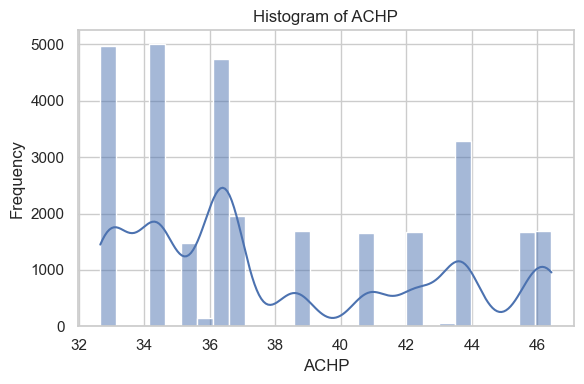

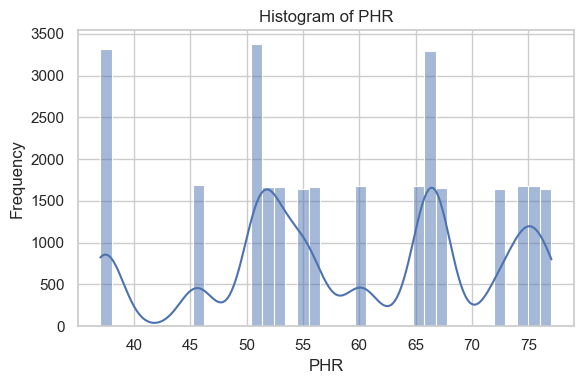

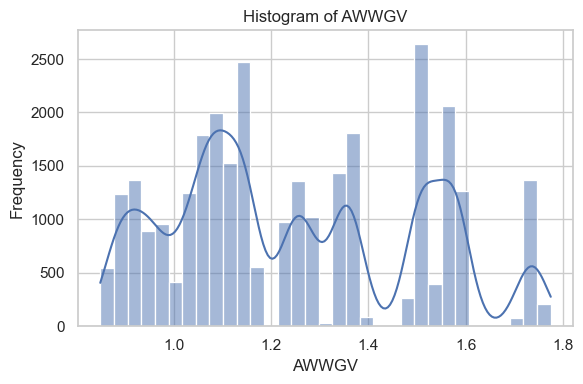

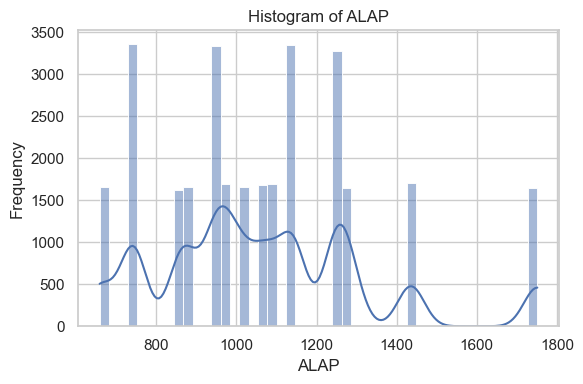

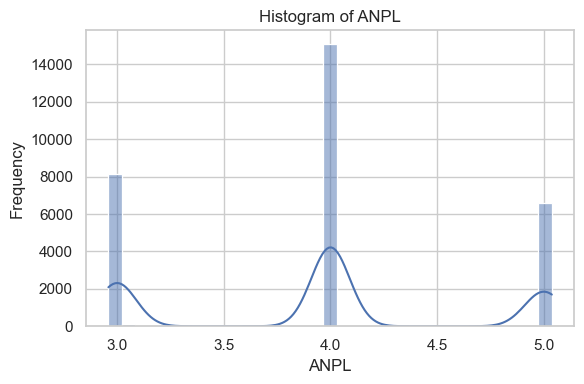

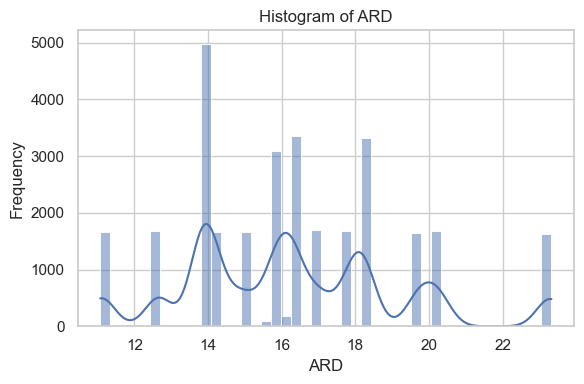

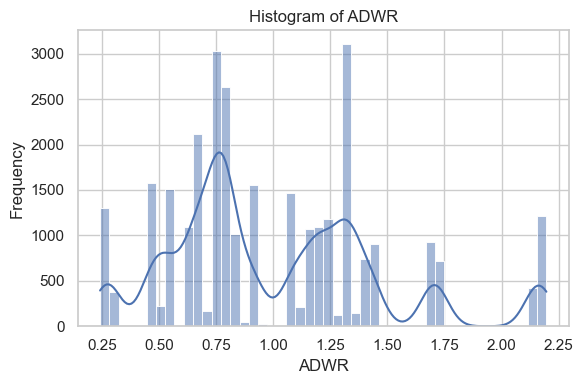

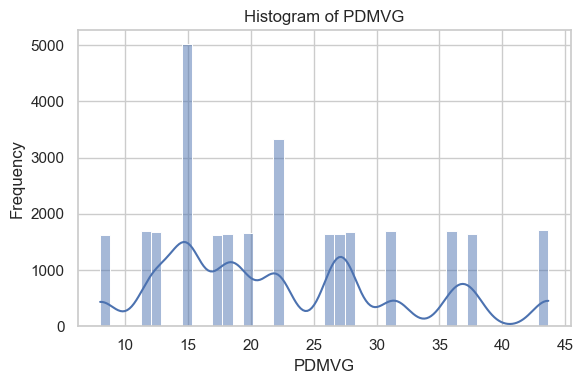

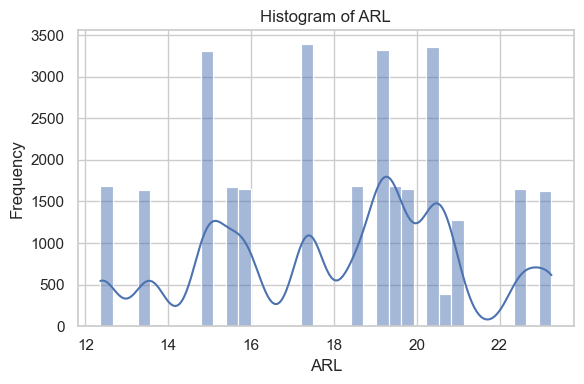

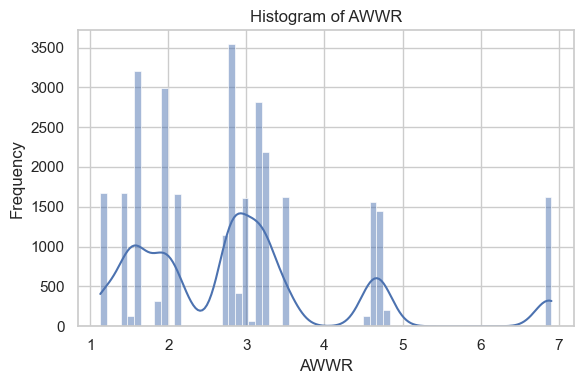

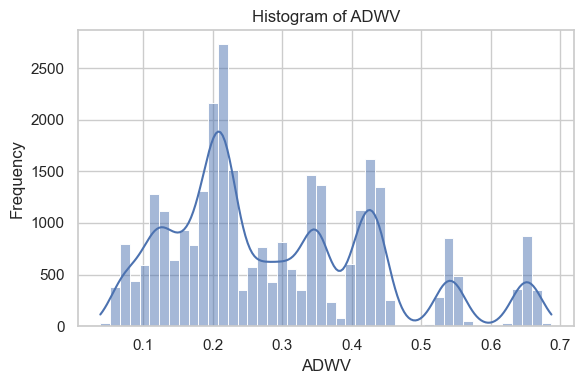

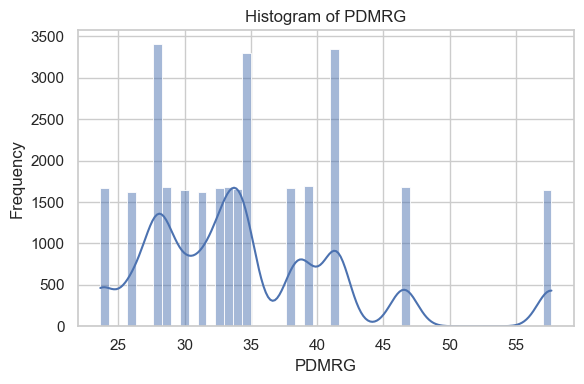

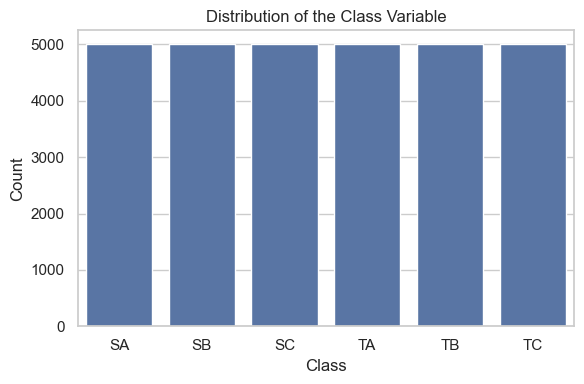

In [16]:
# Plot histogram for each numeric column
numeric_df = df.select_dtypes(include=[np.number])
numeric_columns = numeric_df.columns

for col in numeric_columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
# Inspect the distribution of the 'Class' column using a count plot
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Distribution of the Class Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

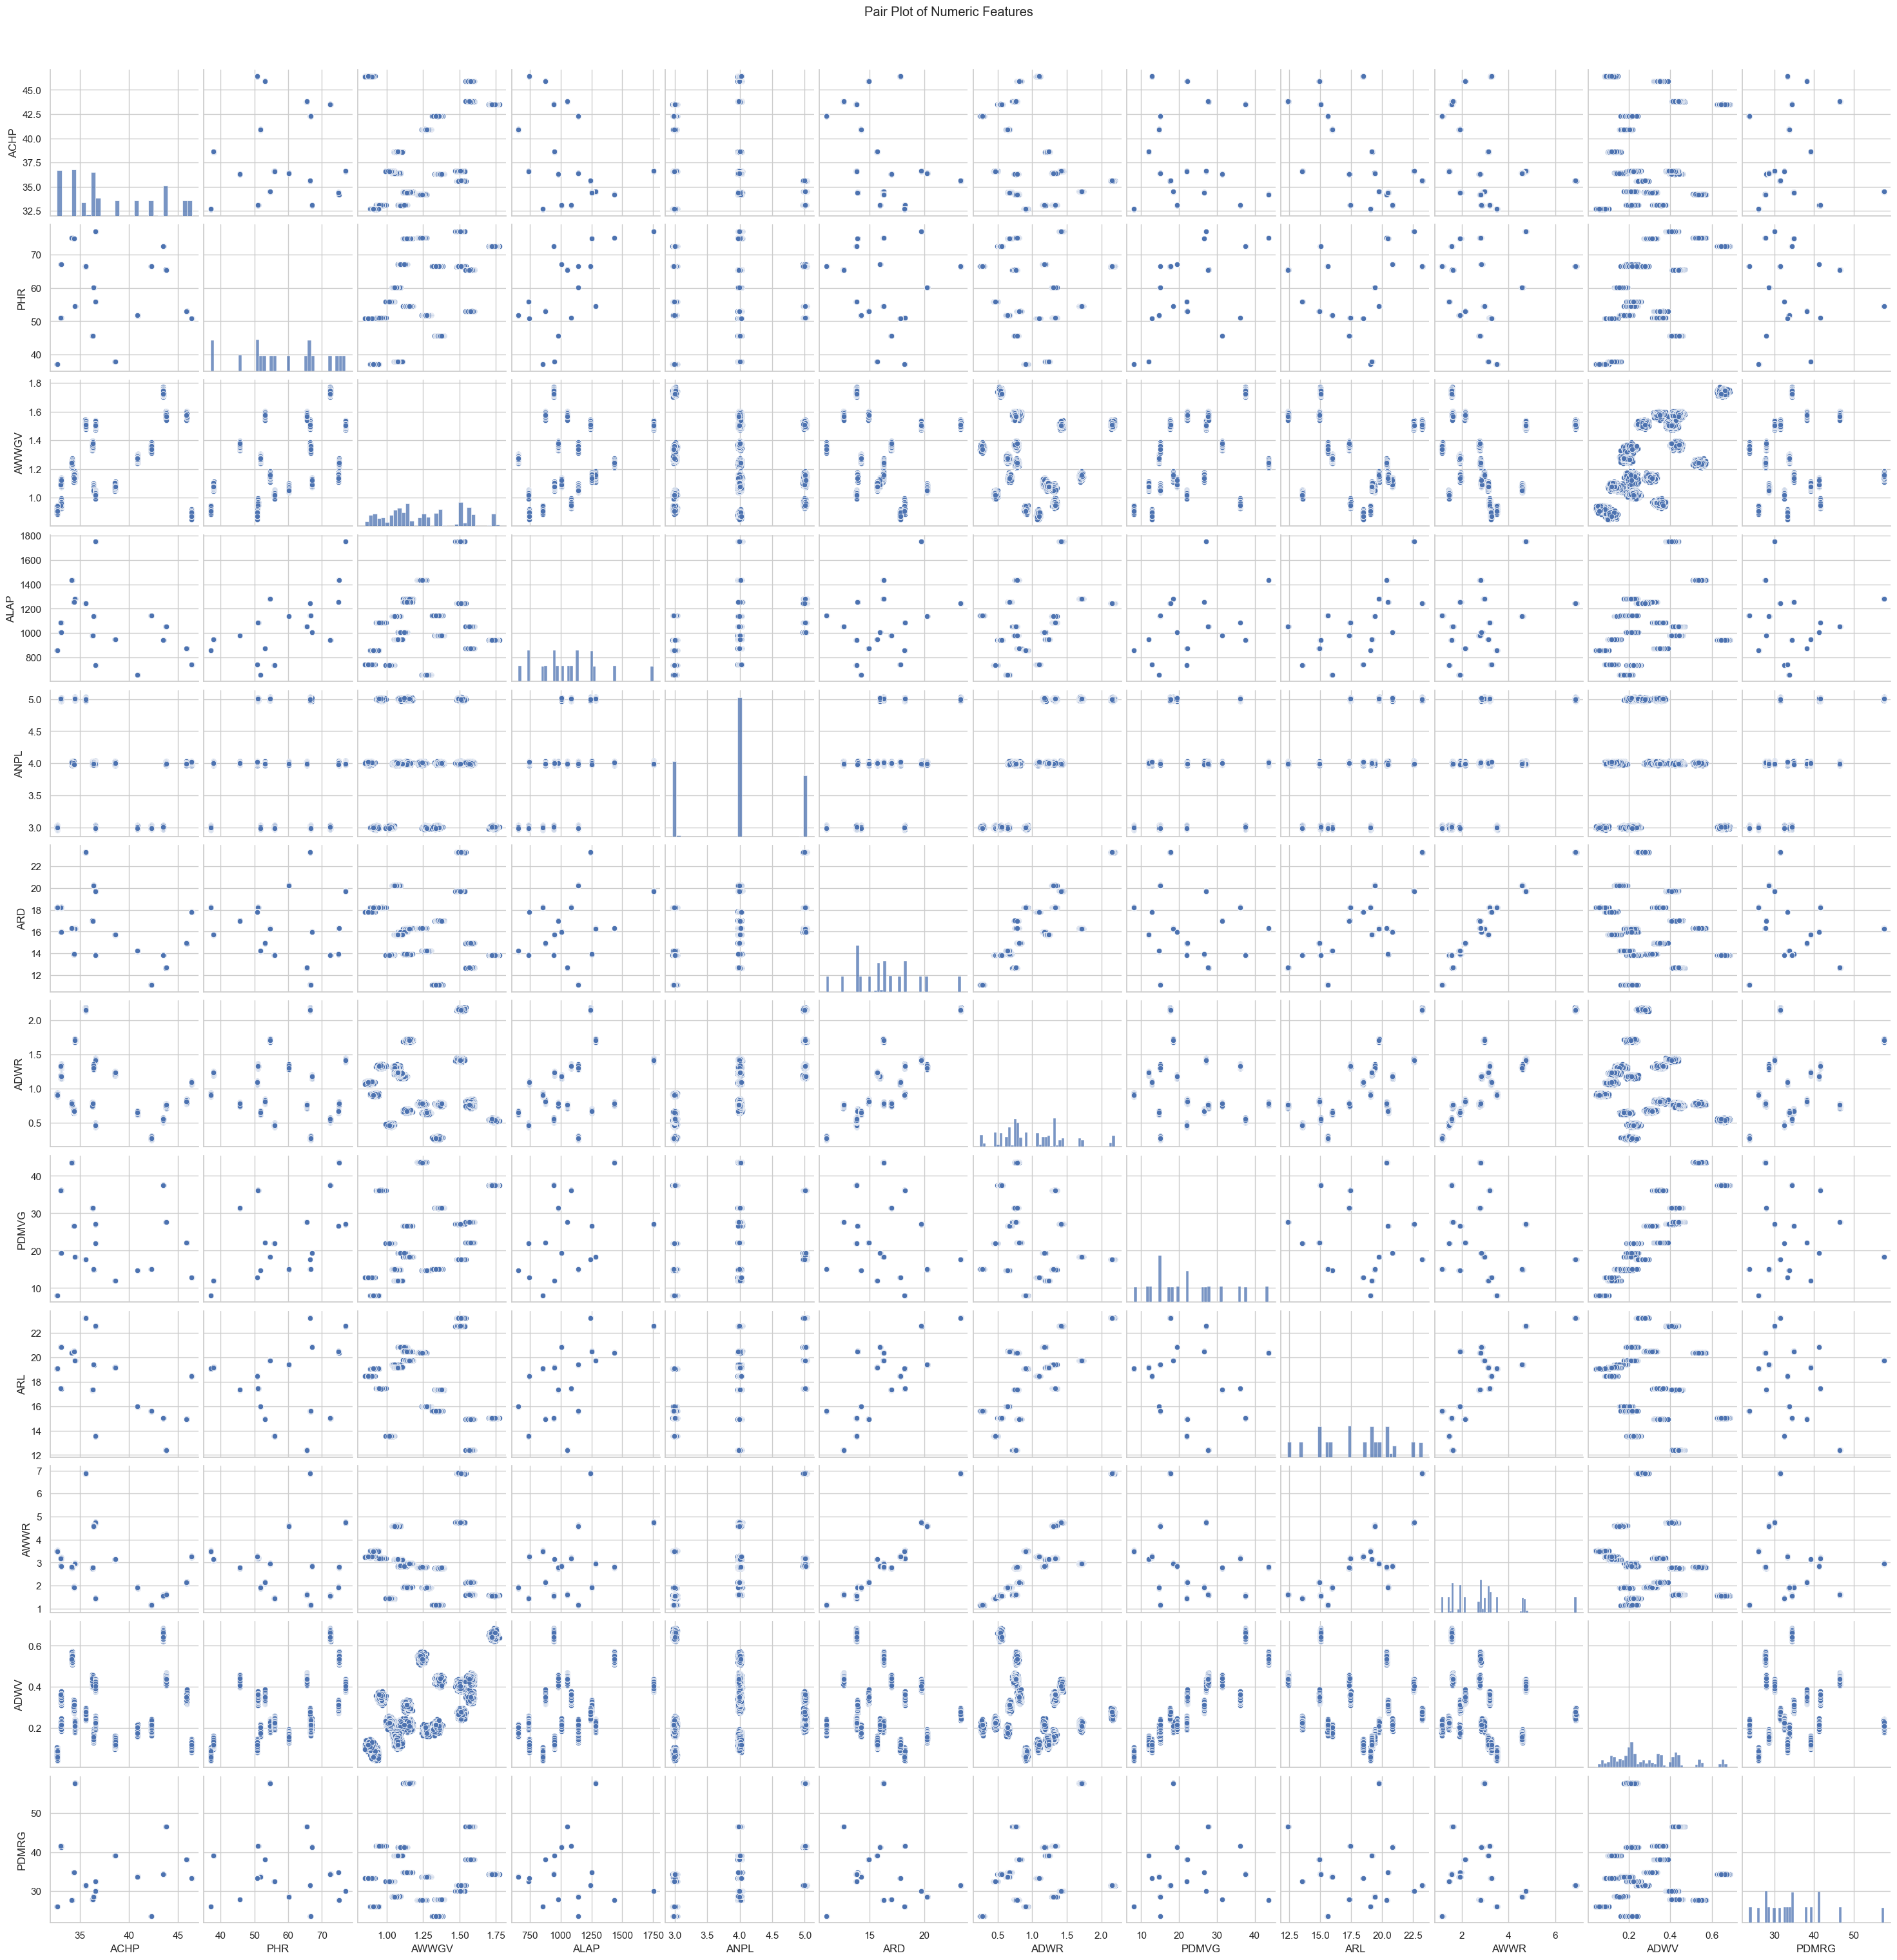

In [18]:
# Create a pair plot to explore relationships between numeric variables
sns.pairplot(numeric_df)
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

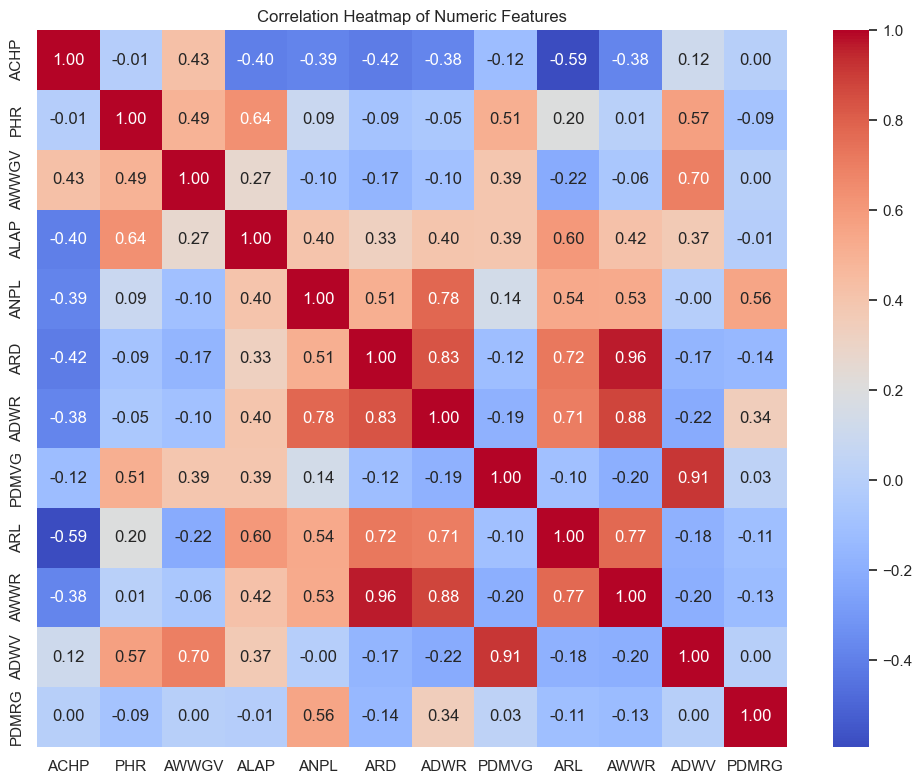

In [20]:
# Create a correlation heatmap if we have enough numeric features (4 or more)
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10,8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric features for a meaningful heatmap.')

### Predictive Modeling - Random Forest Classifier

In [35]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

In [39]:
# Our target variable is 'Class' and features are all other numeric features
X = df.drop(columns=['Class', 'Random'], errors='ignore')  # Exclude 'Random' if not informative
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Instantiate and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

In [41]:
# Compute prediction accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Prediction Accuracy: {accuracy:.4f}')

Prediction Accuracy: 1.0000


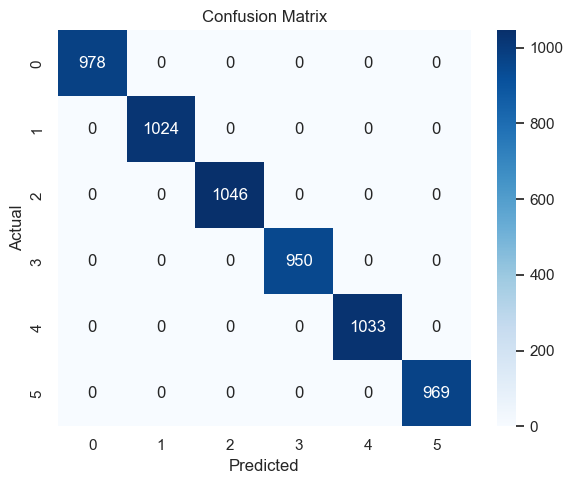

In [43]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

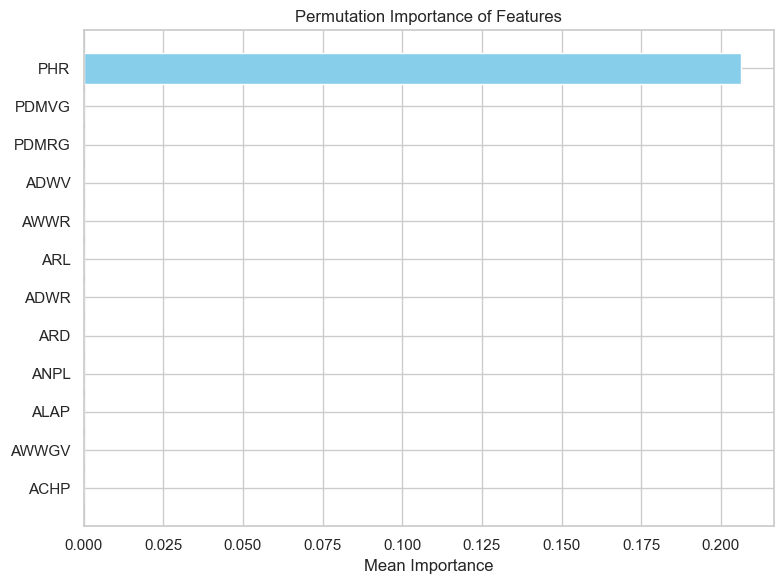

In [45]:
# Permutation Importance to assess feature significance
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': r.importances_mean
}).sort_values(by='importance', ascending=True)

plt.figure(figsize=(8,6))
plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
plt.title('Permutation Importance of Features')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()

In [53]:
import pickle

with open('RF_model.pkl', 'wb') as f:
    pickle.dump(model, f)

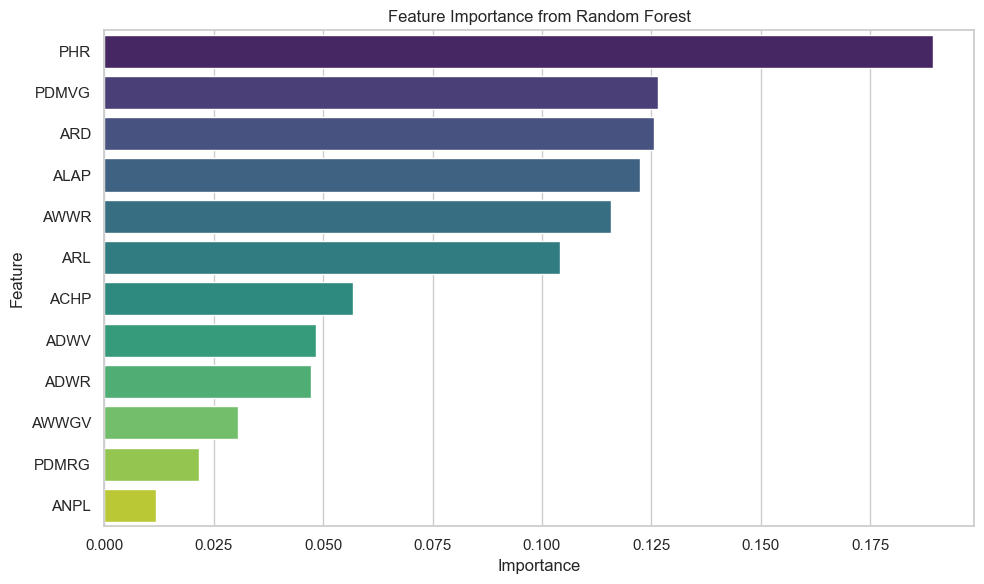

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
importances = model.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

<Axes: xlabel='Class', ylabel='PHR'>

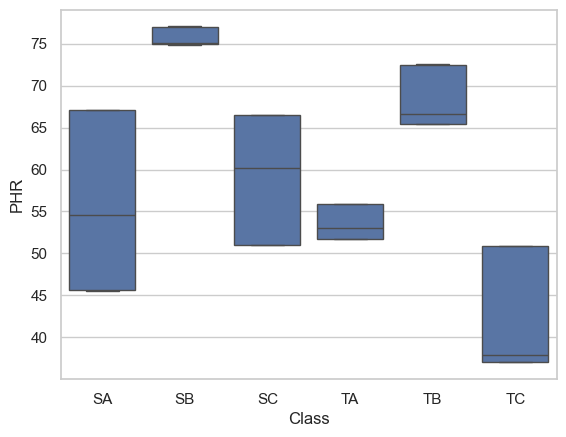

In [51]:
import seaborn as sns
sns.boxplot(x=y, y=X["PHR"])